In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os
import networkit as nk
import datetime
import pandas as pd
import numpy as np
from pylab import rcParams

In [2]:
def shorten(s):
    if(len(s) > 10):
        return s.split('_')[0] + '.'
    else:
        return s

In [3]:
def flatten (l):
    result = []
    for s in l:
        for el in s:
            result.append(el)
    return result

In [4]:
def getDataSeries(df, graph, initialization, maxIterations, sortPaths = False, randomness = False, plateauSize = 0):
    return df.loc[(df['graph'] == graph) 
       &  (df['initialization'] == initialization)
       &  (df['maxIterations'] == maxIterations)
       &  (df['sortPaths'] == sortPaths)
       &  (df['randomness'] == randomness)
       &  (df['plateauSize'] == plateauSize)]

In [5]:
def getEditsMean(df, graph, initialization, maxIterations, sortPaths = False, randomness = False, plateauSize = 0):
    resultSet = getDataSeries(df, graph, initialization, maxIterations, sortPaths, randomness, plateauSize)
    return resultSet['edits_mean'].values[0]

def getEditsMin(df, graph, initialization, maxIterations, sortPaths = False, randomness = False, plateauSize = 0):
    resultSet = getDataSeries(df, graph, initialization, maxIterations, sortPaths, randomness, plateauSize)
    return resultSet['edits_min'].values[0]

def getBestEditsForInit(df, graph, initialization):
    resultSet = df.loc[(df['graph'] == graph) &  (df['initialization'] == initialization)]
    return min(resultSet['edits_mean'].values)

def getUsedIterationsMean(df, graph, initialization, maxIterations, sortPaths = False, randomness = False, plateauSize = 0):
    resultSet = getDataSeries(df, graph, initialization, maxIterations, sortPaths, randomness, plateauSize)
    return resultSet['usedIterations_mean'].values[0]

def getUsedIterationsMax(df, graph, initialization, maxIterations, sortPaths = False, randomness = False, plateauSize = 0):
    resultSet = getDataSeries(df, graph, initialization, maxIterations, sortPaths, randomness, plateauSize)
    return resultSet['usedIterations_max'].values[0]

def getActualPlateauMean(df, graph, initialization, maxIterations, sortPaths = False, randomness = False, plateauSize = 0):
    resultSet = getDataSeries(df, graph, initialization, maxIterations, sortPaths, randomness, plateauSize)
    return resultSet['actualPlateau_mean'].values[0]

def getActualPlateauMax(df, graph, initialization, maxIterations, sortPaths = False, randomness = False, plateauSize = 0):
    resultSet = getDataSeries(df, graph, initialization, maxIterations, sortPaths, randomness, plateauSize)
    return resultSet['actualPlateau_max'].values[0]

def getTime(df, graph, initialization, maxIterations, sortPaths = False, randomness = False, plateauSize = 0):
    resultSet = getDataSeries(df, graph, initialization, maxIterations, sortPaths, randomness, plateauSize)
    return resultSet['time_mean'].values[0]

def getN(df, graph):
    resultSet = df.loc[(df['graph'] == graph)]
    return resultSet['n'].values[0]


def sortPathsEditsEffect(df, graph, initialization, maxIterations):
    on = getEditsMean(df, graph, initialization, maxIterations, True)
    of = getEditsMean(df, graph, initialization, maxIterations, False)
    return ((on/of) - 1) * 100

def sortPathsConvergenceEffect(df, graph, initialization):
    on = getUsedIterationsMean(df, graph, initialization, inf_iterations, True)
    of = getUsedIterationsMean(df, graph, initialization, inf_iterations, False)
    return on - of



def getEditsMeanOverall(df, graph, maxIterations, sortPaths, randomness):
    result_set = (df.loc[(df['graph'] == graph)
        &  (df['initialization'] == 'asc_degree_insert')
       &  (df['maxIterations'] == maxIterations)
       &  (df['sortPaths'] == sortPaths)
       &  (df['randomness'] == randomness)])['edits_mean'].values
    return sum(result_set) / len(result_set)
    

def getEditsMinOverall(df, graph, maxIterations, sortPaths, randomness):
    return min((df.loc[(df['graph'] == graph) 
        &  (df['initialization'] == 'asc_degree_insert')
       &  (df['maxIterations'] == maxIterations)
       &  (df['sortPaths'] == sortPaths)
       &  (df['randomness'] == randomness)])['edits_min'].values)

def initEditsEffect(df, graph, initialization, maxIterations):
    on = getEditsMean(df, graph, initialization, maxIterations, True, False)
    of = getEditsMean(df, graph, 'trivial', maxIterations, True, False)
    return ((on/of) - 1) * 100

def initConvergenceEffect(df, graph, initialization):
    on = getUsedIterationsMean(df, graph, initialization, inf_iterations, True, False)
    of = getUsedIterationsMean(df, graph, 'trivial', inf_iterations, True, False)
    return on - of

def initEditsEffect(df, graph, initialization, maxIterations):
    on = getEditsMean(df, graph, initialization, maxIterations, True, False)
    of = getEditsMean(df, graph, 'trivial', maxIterations, True, False)
    return ((on/of) - 1) * 100

def randomnessMeanEffect(df, graph):
    on = getEditsMeanOverall(df, graph, inf_iterations, True, True)
    of = getEditsMeanOverall(df, graph, inf_iterations, True, False)
    return ((on/of) - 1) * 100

def randomnessMinEffect(df, graph):
    on = getEditsMinOverall(df, graph, inf_iterations, True, True)
    of = getEditsMinOverall(df, graph, inf_iterations, True, False)
    return ((on/of) - 1) * 100

def percentual(percentages):
    percentages.sort(reverse=True)
    
def timeEffect(df_on, df_of, graph, initialization, maxIterations, sortPaths):
    on = getTime(df_on, graph, initialization, maxIterations, sortPaths, False, 0)
    of = getTime(df_of, graph, initialization, maxIterations, sortPaths, False, 0)
    return ((on/of) - 1) * 100
    


In [6]:
def percentualPlot(percentages, legend, name):
    fig, ax = plt.subplots()
    i = 0
    for p in percentages:
        p.sort()
        plt.plot(p, [i+1 for i in range(len(p))], label = legend[i])
        i += 1
    plt.legend(loc='upper center')
    plt.title('Percentual effect of ' + name + ': (p,c) says there are c graphs whith effect <= p%')
    plt.savefig(plot_dir +'percentual_' + name+ '.png', bbox_inches='tight', dpi=300)
    plt.show()
    return 'percentual_' + name+ '.png'

In [7]:
def sortPathsImprovementPlot():

    runs = set(df_full['maxIterations'].tolist())
    
    values = flatten([[sortPathsEditsEffect(df_full, graph, 'asc_degree_insert', run) for run in runs] for graph in graphs])
    labels = flatten([['('+graph+', '+str(run)+')' for run in runs] for graph in graphs])
    colors = ['green' if (x<0) else 'red' for x in values]
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    #rcParams['figure.figsize'] = len(values)*4,len(values)
    plt.ylim([min(values) - 2, max(values)+2])
    plt.axhline(y=0, color='k')
    ax.bar(labels, values, color = colors)
    ax.grid(False)
    plt.title('Effect of reordering simple paths on number of edits(percentual)')
    plt.savefig(plot_dir + 'sortPath_edit_improvements.png')
    plt.show()
    
    values = [sortPathsConvergenceEffect(df_full, graph, 'asc_degree_insert') for graph in graphs]
    colors = ['green' if (x<0) else 'red' for x in values]
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    plt.ylim([min(values) - 1, max(values)+1])
    plt.axhline(y=0, color='k')
    ax.bar(graphs, values, color = colors)
    ax.grid(False)
    plt.title('Effect of reordering simple paths on used Iterations')
    plt.savefig(plot_dir + 'sortPath_convergence_improvements.png', bbox_inches='tight', dpi=300)
    plt.show()

In [8]:
def usedIterationsPlot():
    values = [getUsedIterationsMax(df_full, graph, 'asc_degree_insert', inf_iterations,True,False,0) for graph in graphs]
    x = [getN(df_full, graph) for graph in graphs]
    plt.scatter(x, values)
    plt.title('Used Iterations depending on number of nodes')
    plt.xlabel('n')
    plt.ylabel('usedIterations')
    plt.savefig(plot_dir + 'used_Iterations_n_correlation.png', bbox_inches='tight', dpi=300)
    plt.show()
    return 'used_Iterations_n_correlation.png'
    


In [9]:
def plateauSizePlot():   
    values = [getActualPlateauMax(df_plateauBound, graph, 'asc_degree_insert', 100,True,True,100) for graph in graphs]   
    x = [getN(df_plateauBound, graph) for graph in graphs]
    fig, ax = plt.subplots()
    plt.scatter(x, values)
    plt.title('Plateau Size depending on number of nodes')
    plt.xlabel('n')
    plt.ylabel('Plateau Size')
    plt.savefig(plot_dir + 'plateau_size_n_correlation.png', bbox_inches='tight', dpi=300)
    plt.show()
    return 'plateau_size_n_correlation.png'
    


In [10]:
def initTable(df, edits):
    
    if edits:
        table_name = 'init_table_edits'
        data = np.array(flatten([[[getEditsMean(df, graph, init, 0, True, False, 0) for init in inits], 
            [getEditsMean(df, graph, init, inf_iterations, True, False, 0) for init in inits]] for graph in graphs]))
        rows = [np.array(flatten([[graph, graph] for graph in graphs])), 
            np.array(flatten([['0', 'infty'] for graph in graphs]))]
    else:
        table_name = 'init_table_usedIt'
        data = np.array([[getUsedIterationsMean(df, graph, init, inf_iterations, True, False, 0) for init in inits] for graph in graphs])
        rows = [np.array([graph for graph in graphs])]
    output_df = pd.DataFrame(data, index=rows, columns=inits)
    if edits:
        output_df.index = output_df.index.set_names(['graph', 'it'])
    else:
        output_df.index = output_df.index.set_names(['graph'])
    output_df = output_df.reset_index()
    output_df = output_df.round({'trivial':2, 'editing':2, 'random_insert':2, 'asc_degree_insert':2}) 
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

In [11]:
def initEffectTable(df, edits):
    inits_adv = ['editing', 'random_insert', 'asc_degree_insert']
    
    if edits:
        table_name = 'init_table_edits_effect'
        data = np.array(flatten([[[initEditsEffect(df, graph, init, 0) for init in inits_adv], 
            [initEditsEffect(df, graph, init, inf_iterations) for init in inits_adv]] for graph in graphs]))
        rows = [np.array(flatten([[graph, graph] for graph in graphs])), 
            np.array(flatten([['0', 'infty'] for graph in graphs]))]
    else:
        table_name = 'init_table_usedIt_effect'
        data = np.array([[initConvergenceEffect(df, graph, init) for init in inits_adv] for graph in graphs])
        rows = [np.array([graph for graph in graphs])]
    output_df = pd.DataFrame(data, index=rows, columns=inits_adv)
    if edits:
        output_df.index = output_df.index.set_names(['graph', 'it'])
    else:
        output_df.index = output_df.index.set_names(['graph'])
    output_df = output_df.reset_index()
    output_df = output_df.round({'editing':2, 'random_insert':2, 'asc_degree_insert':2}) 
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

In [12]:
def initEffectTableAvg(df, edits):
    inits_adv = ['editing', 'random_insert', 'asc_degree_insert']
    if(edits):
        table_name = 'init_table_edits_effect_avg'
        output_df = pd.DataFrame(columns=['it']+inits_adv)
        output_df.loc[0] = ['0'] + [sum([initEditsEffect(df, graph, init, 0) for graph in graphs]) / len(graphs) for init in inits_adv]
        output_df.loc[1] = ['infty'] + [sum([initEditsEffect(df, graph, init, inf_iterations) for graph in graphs]) / len(graphs) for init in inits_adv]
    else:
        table_name = 'init_table_usedIt_effect_avg'
        output_df = pd.DataFrame(columns=inits_adv)
        output_df.loc[0] = [sum([initConvergenceEffect(df, graph, init) for graph in graphs]) / len(graphs) for init in inits_adv]
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

In [13]:
def initTableCnt(df):
    table_name = 'init_table_best'
    output_df = pd.DataFrame(columns=['it']+inits)
    best0 = [0,0,0,0]
    bestInfty = [0,0,0,0]
    for graph in graphs:
        best0_val = min((df.loc[(df['graph'] == graph)
           &  (df['maxIterations'] == 0)
           &  (df['sortPaths'] == True)
           &  (df['randomness'] == False)])['edits_mean'].values)
        bestInfty_val = min((df.loc[(df['graph'] == graph)
           &  (df['maxIterations'] == inf_iterations)
           &  (df['sortPaths'] == True)
           &  (df['randomness'] == False)])['edits_mean'].values)
        for i  in range(len(inits)):
            init = inits[i]
            if(getEditsMean(df, graph, init, 0, True, False) == best0_val):
                best0[i] = best0[i] + 1
            if(getEditsMean(df, graph, init, inf_iterations, True, False) == bestInfty_val):
                bestInfty[i] = bestInfty[i] + 1
    output_df.loc[0] = ['0'] + best0
    output_df.loc[1] = ['infty'] + bestInfty
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

In [14]:
def sortPathsTable(df, edits):
    if edits:
        table_name = 'sortPaths_table_edits'
        data = np.array(flatten([[[sortPathsEditsEffect(df, graph, init, 0) for init in inits], 
            [sortPathsEditsEffect(df, graph, init, inf_iterations) for init in inits]] for graph in graphs]))
        rows = [np.array(flatten([[graph, graph] for graph in graphs])), 
           np.array(flatten([['0', 'infty'] for graph in graphs]))]
    else:
        table_name = 'sortPaths_table_usedIt'
        data = np.array([[sortPathsConvergenceEffect(df, graph, init) for init in inits] for graph in graphs])
        rows = [np.array([graph for graph in graphs])]
    output_df = pd.DataFrame(data, index=rows, columns=inits)
    if edits:
        output_df.index = output_df.index.set_names(['graph', 'it'])
    else:
        output_df.index = output_df.index.set_names(['graph'])
    output_df = output_df.reset_index()
    output_df = output_df.round({'trivial':2, 'editing':2, 'random_insert':2, 'asc_degree_insert':2}) 
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name
    
    

    

In [15]:
def sortPathsTableAvg(df, edits):
    if(edits):
        table_name = 'sortPaths_table_edits_avg'
        output_df = pd.DataFrame(columns=['it']+inits)
        output_df.loc[0] = ['0'] + [sum([sortPathsEditsEffect(df, graph, init, 0) for graph in graphs]) / len(graphs) for init in inits]
        output_df.loc[1] = ['infty'] + [sum([sortPathsEditsEffect(df, graph, init, inf_iterations) for graph in graphs]) / len(graphs) for init in inits]
    else:
        table_name = 'sortPaths_table_usedIt_avg'
        output_df = pd.DataFrame(columns=inits)
        output_df.loc[0] = [sum([sortPathsConvergenceEffect(df, graph, init) for graph in graphs]) / len(graphs) for init in inits]
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

In [16]:
def randomnessTable(df):
    table_name = 'randomness_table'
    output_df = pd.DataFrame(columns=['graph', 'off', 'mean', 'min'])
    for g in range(len(graphs)):
        graph = graphs[g]
        off_data = getEditsMeanOverall(df, graph, inf_iterations, True, False)
        mean_data = getEditsMeanOverall(df, graph, inf_iterations, True, True)
        min_data = getEditsMinOverall(df, graph, inf_iterations, True, True)
        output_df.loc[g] = [graph, off_data, mean_data, min_data]
    output_df = output_df.round({'off':2, 'mean':2, 'min':2}) 
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

In [17]:
def randomnessEffectTable(df):
    table_name = 'randomness_effect_table'
    output_df = pd.DataFrame(columns=['graph', 'mean', 'min'])
    for g in range(len(graphs)):
        graph = graphs[g]
        mean_data = randomnessMeanEffect(df, graph)
        min_data = randomnessMinEffect(df, graph)
        output_df.loc[g] = [graph, mean_data, min_data]
    output_df = output_df.round({'mean':2, 'min':2}) 
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

In [18]:
def randomnessEffectTableAvg(df):
    table_name = 'randomness_effect_table_avg'
    output_df = pd.DataFrame(columns=['mean', 'min'])
    output_df.loc[0] = [sum([randomnessMeanEffect(df, graph) for graph in graphs]) / len(graphs),
                        sum([randomnessMinEffect(df, graph) for graph in graphs]) / len(graphs)]
    output_df = output_df.round({'mean':3, 'min':3}) 
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

In [19]:
def plateauTable(df):
    table_name = 'plateau_table'
    plateauSizes = [2,5,10]
    output_df = pd.DataFrame(columns=['graph']+plateauSizes)
    for g in range(len(graphs)):
        graph = graphs[g]
        data = [getEditsMin(df, graph, 'asc_degree_insert', inf_iterations, True, True, p) for p in plateauSizes]
        output_df.loc[g] = [graph] + data
    #output_df = output_df.round({'off':2, 'mean':2, 'min':2}) 
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

In [20]:
def bucketQueueTable(df_on, df_off):
    table_name = 'bucketQueue_table'
    output_df = pd.DataFrame(columns=['graph' , 'effect on time'])
    for g in range(len(graphs)):
        graph = graphs[g]
        output_df.loc[g] = [graph, timeEffect(df_on, df_off, graph, 'asc_degree_insert', inf_iterations, True)]
    print(output_df)
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    return table_name

      it    editing  random_insert  asc_degree_insert
0      0 -59.966475     -75.952708         -71.647541
1  infty  -0.547974      -0.084479           0.210489
      it  trivial  editing  random_insert  asc_degree_insert
0      0        0        0             45                  5
1  infty        6       22              6                 16
   editing  random_insert  asc_degree_insert
0  -0.8304         -1.307            -1.1058


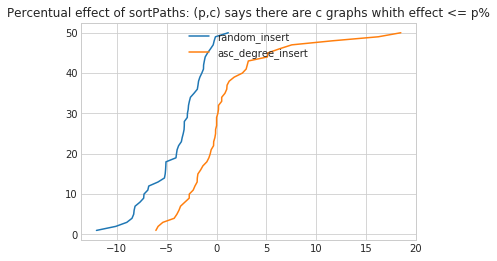

      it   trivial   editing  random_insert  asc_degree_insert
0      0  0.000000  0.000000      -4.036365           0.616121
1  infty -1.327857 -1.275742      -1.439613          -2.458366
   trivial  editing  random_insert  asc_degree_insert
0   0.0504  -0.0088         0.0266            -0.1736
   mean    min
0 -0.52 -0.912


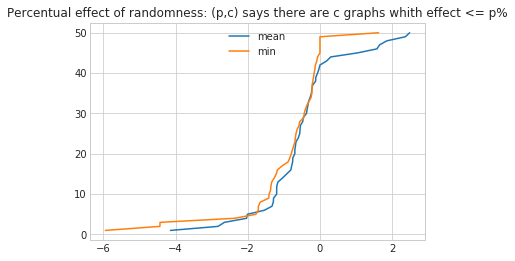

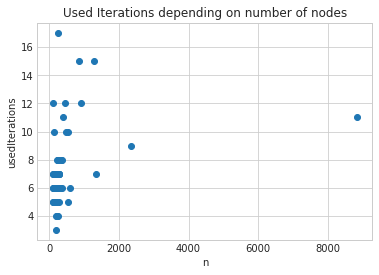

In [21]:
def plot(g, small):
    global inits
    inits = ['trivial', 'editing', 'random_insert', 'asc_degree_insert']
    global inf_iterations
    inf_iterations = 100
    global graph_set
    graph_set = g
    global plot_dir
    plot_dir = '../output/QTM/' + graph_set + '/plots/'
    global tex_dir
    tex_dir = '../output/QTM/' + graph_set + '/tex/'
    global data_path
    data_path = '../output/QTM/' + graph_set + '/'
    
    global df_full
    #global df_plateauBound
    #global df_wbq
    global graphs
    df_full = pd.read_csv(data_path + graph_set + '_full.csv')
    #df_plateauBound = pd.read_csv(data_path + graph_set + '_plateauBound.csv')
    #df_wbq = pd.read_csv(data_path + graph_set + '_withoutBucketQueue.csv')
    graphs = list(set(df_full['graph'].tolist()))

    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    if not os.path.exists(tex_dir):
        os.makedirs(tex_dir)
        
    #sortPathsImprovementPlot()
   
    
    output_file = open(tex_dir + 'tabels.tex', 'w+')
    output_file.write('\documentclass{article}\n')
    output_file.write('\\usepackage{booktabs}\n')
    output_file.write('\\usepackage{graphicx}\n')
    output_file.write('\\begin{document}\n')
    output_file.write('\\noindent\n')
    
    if small:
        output_file.write('Resulting number of edits for different initializations\\\\\nsortPaths = True, randomness = False\n')
        output_file.write('\\\\\n')
        output_file.write('\input{./' + initTable(df_full, True) + '.tex}\n')
        output_file.write('\\\\ \\\\\n')
        output_file.write('Effect of advanced initializtaion on achieved edits (percentual, in comp. to trivial initialization)\\\\\nsortPaths = True, randomness = False\n')
        output_file.write('\\\\\n')
        output_file.write('\input{./' + initEffectTable(df_full, True) + '.tex}\n')
        output_file.write('\\newpage \n \\noindent ')
    
    
    output_file.write('Average effect of advanced initializtaion on achieved edits (percentual, in comp. to trivial initialization)\\\\\nsortPaths = True, randomness = False\n')
    output_file.write('\\\\\n')
    output_file.write('\input{./' + initEffectTableAvg(df_full, True) + '.tex}\n')
    output_file.write('\\\\ \\\\\n')
    output_file.write('Number of graphs for which the initialization leads to the smallest number of edits among all initializations \\\\\nsortPaths = True, randomness = False\n')
    output_file.write('\\\\\n')
    output_file.write('\input{./' + initTableCnt(df_full) + '.tex}\n')
    output_file.write('\\newpage \n \\noindent ')
    
    if small:
        output_file.write('Used iterations with different initializations\\\\\nsortPaths = True, randomness = False\n')
        output_file.write('\\\\\n')
        output_file.write('\input{./' + initTable(df_full, False) + '.tex}\n')
        output_file.write('\\\\ \\\\\n')
        output_file.write('Effect of advanced initialization on used Iterations (in comp. to trivial intialization)\\\\\nsortPaths = True, randomness = False\n')
        output_file.write('\\\\\n')
        output_file.write('\input{./' + initEffectTable(df_full, False) + '.tex}\n')
        output_file.write('\\\\ \\\\\n')
    output_file.write('Average effect of advanced initialization on used Iterations (in comp. to trivial intialization)\\\\\nsortPaths = True, randomness = False\n')
    output_file.write('\\\\\n')
    output_file.write('\input{./' + initEffectTableAvg(df_full, False) + '.tex}\n')
    output_file.write('\\newpage \n \\noindent ')
    
    output_file.write('\includegraphics[width=\\textwidth]{../plots/' + 
                      percentualPlot([[sortPathsEditsEffect(df_full, graph, init, 0) for graph in graphs] for init in ['random_insert', 'asc_degree_insert']],
                  ['random_insert', 'asc_degree_insert'], 'sortPaths')
                      + '}\n')
    output_file.write('\\newpage \n \\noindent ')
    
    if small:
        output_file.write('Effect of reordering paths on edits (percentual)\\\\\nrandomness = False\n')
        output_file.write('\\\\\n')
        output_file.write('\input{./' + sortPathsTable(df_full, True) + '.tex}\n')
        output_file.write('\\\\\n')
    output_file.write('Average effect of sorting paths on edits(percentual)\\\\\nsortPaths = True, randomness = False\n')
    output_file.write('\\\\\n')
    output_file.write('\input{./' + sortPathsTableAvg(df_full, True) + '.tex}\n')
    output_file.write('\\\\ \\\\\n')
    if small:
        output_file.write('Effect of reordering paths on used Iterations \\\\\nrandomness = False\n')
        output_file.write('\\\\\n')
        output_file.write('\input{./' + sortPathsTable(df_full, False) + '.tex}\n')
        output_file.write('\\\\ \\\\\n')
    output_file.write('Average effect of sorting paths on number of used Iterations\\\\\nsortPaths = True, randomness = False\n')
    output_file.write('\\\\\n')
    output_file.write('\input{./' + sortPathsTableAvg(df_full, False) + '.tex}\n')
    output_file.write('\\newpage \n \\noindent ')
    
    if small:
        output_file.write('Resulting edits using randomness\\\\\ninit = asc\_degree\_insert, sortPaths = true, maxIterations = infty\n')
        output_file.write('\\\\\n')
        output_file.write('\input{./' + randomnessTable(df_full) + '.tex}\n')
        output_file.write('\\\\ \\\\\n')
        output_file.write('Effect on edits using randomness (percentual)\\\\\ninit = asc\_degree\_insert, sortPaths = true, maxIterations = infty\n')
        output_file.write('\\\\\n')
        output_file.write('\input{./' + randomnessEffectTable(df_full) + '.tex}\n')
        output_file.write('\\\\ \\\\\n')
        output_file.write('Minimal edits using randomness with different plateaus\\\\\ninit = asc\_degree\_insert, sortPaths = true, maxIterations = infty\n')
        output_file.write('\\\\\n')
        output_file.write('\input{./' + plateauTable(df_full) + '.tex}\n')
        output_file.write('\\\\ \\\\\n')
    output_file.write('Average effect on edits using randomness (percentual)\\\\\ninit = asc\_degree\_insert, sortPaths = true, maxIterations = infty\n')
    output_file.write('\\\\\n')
    output_file.write('\input{./' + randomnessEffectTableAvg(df_full) + '.tex}\n')
    output_file.write('\\newpage \n \\noindent ')
    
    output_file.write('\includegraphics[width=\\textwidth]{../plots/' + 
                          percentualPlot([[randomnessMeanEffect(df_full, graph) for graph in graphs],[randomnessMinEffect(df_full, graph) for graph in graphs]],
                   ['mean', 'min'], 'randomness')
                      + '}\n')
    output_file.write('\\newpage \n \\noindent ')
    
    output_file.write('\includegraphics[width=\\textwidth]{../plots/' + usedIterationsPlot() + '}\n')
    output_file.write('\\newpage \n \\noindent ')
    
    #output_file.write('\includegraphics[width=\\textwidth]{../plots/' + plateauSizePlot() + '}\n')
    #output_file.write('\\newpage \n \\noindent ')
    
    if small:
            output_file.write('Effect of bucket queue on runtime (percentual)\\\\\ninit = asc\_degree\_insert, sortPaths = true, maxIterations = infty\n')
            output_file.write('\\\\\n')
            output_file.write('\input{./' + bucketQueueTable(df_full, df_wbq) + '.tex}\n')
            output_file.write('\\newpage \n \\noindent ')
    
    output_file.write('\end{document}\n')
    
    output_file.close()

    #pdfl = PDFLaTeX.from_texfile(tex_dir + 'tabels.tex')
    #pdf, log, completed_process = pdfl.create_pdf(keep_pdf_file=True, keep_log_file=True)

plot("biological", False)